## Model Training & Optimization

This file serves as the **core learning engine**, where the multimodal neural network is constructed, trained, and validated.

### It covers:
- **Data Pipeline Setup** – Converts cleaned data into PyTorch tensors, applies scaling to numerical features, and creates batched DataLoaders  
- **Architecture Initialization** – Instantiates the custom `ValuationModel` (fusing ResNet-based vision with tabular data) and assigns it to the GPU  
- **Training Loop** – The iterative process where the model processes images and statistics, computes loss, and updates weights  
- **Validation & Monitoring** – Evaluates performance on unseen data after each epoch to ensure generalization  
- **Model Serialization** – Saves the trained model (`model.pth`) for reuse in future predictions


In [9]:
'''
  All impoorts modules n libs stay here in this block
'''

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pandas as pd
from tqdm.auto import tqdm  # To watch training via loadin bars
import matplotlib.pyplot as plt

# Custom Modules
from src.dataset import SatelliteDataset
from src.models import ValuationModel

# Hyperparameters
BATCH_SIZE = 32        # Study 32 houses at a time
LEARNING_RATE = 0.0001  # How fast the AI updates its beliefs/ the alpha looking parameter in eqn.
NUM_EPOCHS = 10        # TO make it read the entire dataset 15 times
SEED = 42              # Ensures we get the same result every time
                       # Debuggin and proof purposes.

---
#### Run the cell below to verify whether training is happening on GPU or CPU.  
Would prefer using `CUDA` to fasten up process.

In [10]:
# Setup Device (Uses GPU if you have one, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device For Training: {DEVICE}")

# Set Random Seed for Consistency
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Device For Training: cuda


---
#### Now we Load the DATA

In [11]:
# Loading the CSVs created during preprocessing.ipynb
# We use the cleaned versions because they have 0s instead of NaNs
print("Loading cleaned Data")
train_df = pd.read_csv("data/train_cleaned.csv")
test_df = pd.read_csv("data/test_cleaned.csv")

print(f"Data Loaded")
print(f"   - Train Rows: {len(train_df)}")
print(f"   - Test Rows:  {len(test_df)}")

# Defining the Feature Columns/
# Its like telling the Dataset which columns are "inputs"
feature_cols = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
    "sqft_living15",
    "sqft_lot15",
    "lat",
    "long",
]

# A quick Check Ensure we have 17 columns
print(f"   - Features used: {len(feature_cols)}")

Loading cleaned Data
Data Loaded
   - Train Rows: 16209
   - Test Rows:  5404
   - Features used: 17


---
Data Scaling as well as loading the data using `DataLoader` (PyTorch utility that efficiently feeds the data during the training)  
We also split the data for `ValidationSet` here

In [12]:
# DATA SPLIT, SCALE, AND LOAD

import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import train_test_split
from src.dataset import SatelliteDataset 

print("Preparing Data Pipeline...")

# SPLIT DATAFRAME FIRST (Crucial for correct scaling)
# We split the raw 'train_df' into Train (80%) and Val (20%) BEFORE scaling
train_split, val_split = train_test_split(train_df, test_size=0.2, random_state=42)

# CREATE LOG TARGET (The "Small Numbers" Fix)
# We add a new column for the model to learn
train_split['log_price'] = np.log1p(train_split['price'])
val_split['log_price'] = np.log1p(val_split['price']) 
print("   >> Created 'log_price' column.")

# SCALE FEATURES (The "Ruler" Fix)
print("Scaling Input Features...")
scaler = StandardScaler()

# Fit on TRAIN split only, then transform BOTH
# We use .copy() to avoid SettingWithCopy warnings
train_split = train_split.copy()
val_split = val_split.copy()

train_split[feature_cols] = scaler.fit_transform(train_split[feature_cols])
val_split[feature_cols] = scaler.transform(val_split[feature_cols])

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")
print("   >> Saved scaler to models/scaler.pkl")

# DEFINE IMAGE TRANSFORMS
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CREATE DATASETS (Pointing to the new Log Column)
train_dataset = SatelliteDataset(
    dataframe=train_split,
    image_dir="data/images",  
    transform=transform,
    feature_cols=feature_cols,
    target_col='log_price'    
)

val_dataset = SatelliteDataset(
    dataframe=val_split,
    image_dir="data/images",
    transform=transform,
    feature_cols=feature_cols,
    target_col='log_price'
)

# LOADERS
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Loaders Ready:")
print(f"   - Training Samples:   {len(train_dataset):,}")
print(f"   - Validation Samples: {len(val_dataset):,}")

Preparing Data Pipeline...
   >> Created 'log_price' column.
Scaling Input Features...
   >> Saved scaler to models/scaler.pkl
Data Loaders Ready:
   - Training Samples:   12,967
   - Validation Samples: 3,242


---
- This Cell is the to Train the model / Training loop.
- ReRun would simply restart the whole trainin process once again, which is no harm and also useful to tweak HyperParams

In [13]:
# We must create the model variable before we can train it.
model = ValuationModel(num_tabular_features=17).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model & Optimizer Initialized.")

# Since we run the look NUM_EPOCHS times..
print(f"Starting Training for {NUM_EPOCHS} Epochs")
# Lists to store our progress (so we can report it later)
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    # --- PHASE of TRAINING ---
    model.train()  # "Learning Mode"
    running_loss = 0.0
    
    # tqdm creates the ascii-loading bar, since we dont run in terminal.
    loop = tqdm(train_loader)
    
    for batch_idx, (images, features, prices) in enumerate(loop):
        # Move data to GPU
        images = images.to(DEVICE)
        features = features.to(DEVICE)
        prices = prices.to(DEVICE).float().unsqueeze(1) # Make sure shape is [Batch, 1]
        
        # Forward Pass (Guess the price)
        predictions = model(images, features)
        
        # Calculate loss
        loss = criterion(predictions, prices)
        
        # Backward Pass (kind of learning from the mistake)
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update weights
        
        # Track progress
        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- PHASE of VALIDATION (The Practice) ---
    model.eval() # "Testing Mode" 
    val_loss = 0.0
    
    with torch.no_grad(): # Not calculating gradients (since it saves memory/time)
        for images, features, prices in val_loader:
            images = images.to(DEVICE)
            features = features.to(DEVICE)
            prices = prices.to(DEVICE).float().unsqueeze(1)
            
            predictions = model(images, features)
            loss = criterion(predictions, prices)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"   Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Training Complete.") ### SUCCESSSSSS

Model & Optimizer Initialized.
Starting Training for 10 Epochs


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 21.5753 | Val Loss: 0.3092


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 1.3158 | Val Loss: 0.1396


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 1.1432 | Val Loss: 0.0953


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 1.0508 | Val Loss: 0.2103


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 1.0397 | Val Loss: 0.2621


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 0.9900 | Val Loss: 0.3336


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 0.9383 | Val Loss: 0.6517


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 0.9378 | Val Loss: 0.9443


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 0.8673 | Val Loss: 1.4083


  0%|          | 0/406 [00:00<?, ?it/s]

   Train Loss: 0.7756 | Val Loss: 2.1840
Training Complete.


---
This cell saves the just trained model in the above cell and stores it via date n time (timestamp basically) in a folder named `models/`

In [14]:
'''
import os
import time
'''

# 1. Create a "models" folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# 2. Generate a name with a timestamp (e.g., valuation_model_20260107-1430.pth)
# This prevents us from accidentally overwriting old good models.
timestamp = time.strftime("%Y%m%d-%H%M%S")
save_filename = f"valuation_model_{timestamp}.pth"
save_path = os.path.join("models", save_filename)

# 3. Save the Brain (State Dictionary)
torch.save(model.state_dict(), save_path)

print(f"   SUCCESS! Model saved to: {save_path}")
print("   (You can now see this file in your project folder)")

   SUCCESS! Model saved to: models\valuation_model_20260107-232038.pth
   (You can now see this file in your project folder)


---
By runnin this cell we get to know how good our Training process went.

Graph saved as 'reports/training_curve.png'


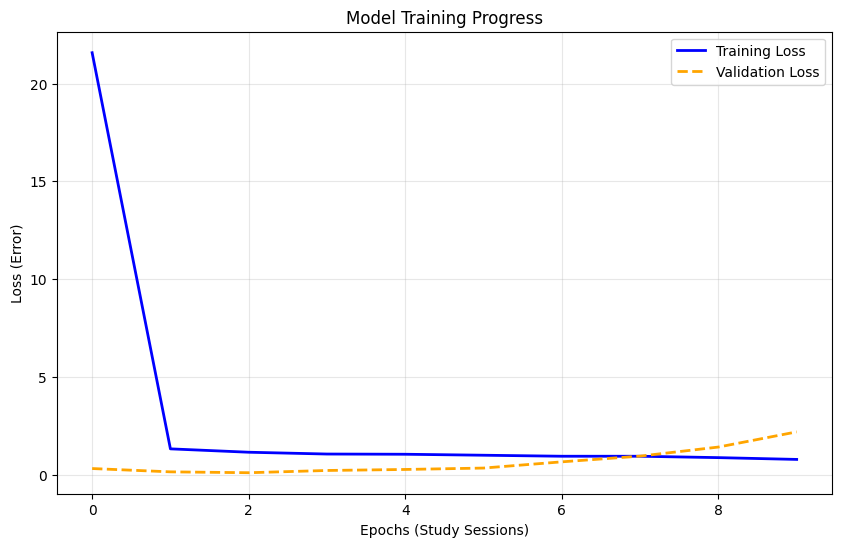

In [15]:
'''
import matplotlib.pyplot as plt
'''

plt.figure(figsize=(10, 6))

# Plot the "Study" error (Training)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)

# Plot the "Test" error (Validation)
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Epochs (Study Sessions)')
plt.ylabel('Loss (Error)')
plt.title('Model Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Saving plot for the future reports/.
plt.savefig("reports/training_curve.png", dpi=300, bbox_inches="tight")
print("Graph saved as 'reports/training_curve.png'")
plt.show()